In [1]:
# Advanced SMS Spam Detection Using Language Models
#This notebook explores the application of a pre-trained language model to classify SMS messages as spam or legitimate. We'll use advanced techniques including text preprocessing, visualization, model predictions, and performance evaluation.


In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline, DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Load tokenizer and model from Transformers
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Load a pre-trained pipeline for classification (if applicable)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [4]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
print(df.head())
print("\nDistribution of classes:")
print(df['v1'].value_counts())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Distribution of classes:
v1
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
# Function to preprocess text
def preprocess_text(text_series):
    return text_series.str.replace('[^\w\s]', '').str.lower()

# Apply preprocessing
df['processed_text'] = preprocess_text(df['v2'])


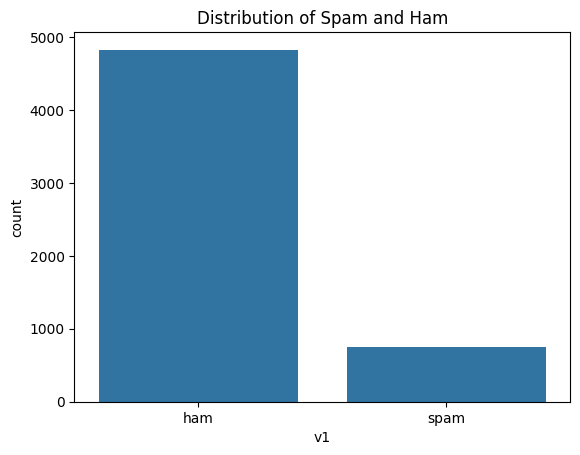

In [6]:
# Visualize the distribution of spam vs ham
sns.countplot(x=df['v1'])
plt.title('Distribution of Spam and Ham')
plt.show()


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['v1'], test_size=0.2, random_state=42)


In [8]:
# Encode text data using tokenizer
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [9]:
# Convert data to TensorFlow dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.map({'spam': 1, 'ham': 0}).values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.map({'spam': 1, 'ham': 0}).values
))


In [10]:
# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16)


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
279/279 [==============================] - 5867s 21s/step - loss: 0.0805 - accuracy: 0.9744


In [11]:
# Evaluate the model
model.evaluate(test_dataset.batch(16))


70/70 [==============================] - 436s 6s/step - loss: 0.0240 - accuracy: 0.9937


[0.02399207092821598, 0.9937219619750977]

70/70 [==============================] - 418s 6s/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       965
           1       0.99      0.97      0.98       150

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



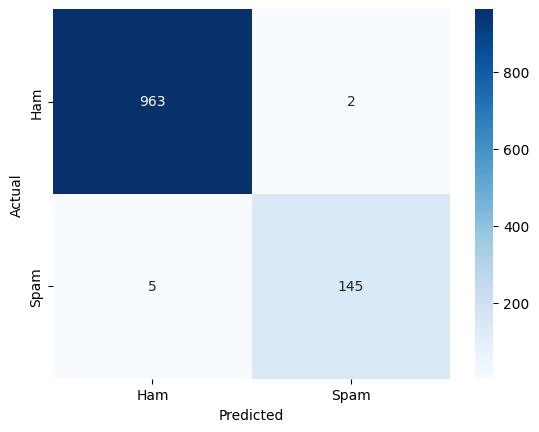

In [12]:
# Predict on test data
y_pred = np.argmax(model.predict(test_dataset.batch(16)).logits, axis=-1)
print(classification_report(y_test.map({'spam': 1, 'ham': 0}), y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test.map({'spam': 1, 'ham': 0}), y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [14]:
# Function to classify user input
def classify_user_input():
    input_sms = input("Enter an SMS message to classify: ")
    prediction = classifier(input_sms)[0]
    print("The message is classified as:", "SPAM" if prediction['label'] == 'LABEL_1' else "HAM")

classify_user_input()


Enter an SMS message to classify: Hey ! How are You ?
The message is classified as: HAM


In [15]:
def classify_user_input():
    input_sms = input("Enter an SMS message to classify: ")
    prediction = classifier(input_sms)[0]
    print("The message is classified as:", "SPAM" if prediction['label'] == 'LABEL_1' else "HAM")

classify_user_input()

Enter an SMS message to classify: Hey ! We are happy to inform you that you won 50 cashback on recent purchase
The message is classified as: SPAM


In [16]:
## Conclusion
#In this notebook, we applied a pre-trained DistilBERT model to classify SMS messages, incorporating advanced NLP techniques and TensorFlow for deep learning. We evaluated the model with various metrics and provided a real-time test interface for user inputs.
